In [181]:
import rosbag
import matplotlib.pyplot as plt
from scipy import integrate
plt.style.use('seaborn-whitegrid')
import pandas as pd
import numpy as np
import bagpy
from bagpy import bagreader

In [182]:
read = bagreader('the_journey_2022-10-22-17-34-28.bag')
read_stats = read.message_by_topic('/imu')
gps_data = read.message_by_topic('/gps')
gps_df = pd.read_csv(gps_data)
imu_df = pd.read_csv(read_stats)

time_secs = imu_df['Header.stamp.secs']
time_nsecs = imu_df['Header.stamp.nsecs']
time = time_secs + time_nsecs * 1e-9
time = time - time[0]

[INFO]  Data folder the_journey_2022-10-22-17-34-28 already exists. Not creating.


In [183]:
#ellipse fitting to 2d points

def fit_ellipse(x,y):
    x = x[:,np.newaxis]
    y = y[:,np.newaxis]
    D =  np.hstack((x*x, x*y, y*y, x, y, np.ones_like(x)))
    S = np.dot(D.T,D)
    C = np.zeros([6,6])
    C[0,2] = C[2,0] = 2; C[1,1] = -1
    E, V =  np.linalg.eig(np.dot(np.linalg.inv(S), C))
    n = np.argmax(np.abs(E))
    a = V[:,n]
    return a

def ellipse_center(a):
    b,c,d,f,g,a = a[1]/2, a[2], a[3]/2, a[4]/2, a[5], a[0]
    num = b*b-a*c
    x0=(c*d-b*f)/num
    y0=(a*f-b*d)/num
    return np.array([x0,y0])

def ellipse_angle_of_rotation( a ):
    b,c,d,f,g,a = a[1]/2, a[2], a[3]/2, a[4]/2, a[5], a[0]
    return 0.5*np.arctan(2*b/(a-c))

def ellipse_axis_length( a ):
    b,c,d,f,g,a = a[1]/2, a[2], a[3]/2, a[4]/2, a[5], a[0]
    up = 2*(a*f*f+c*d*d+g*b*b-2*b*d*f-a*c*g)
    down1=(b*b-a*c)*( (c-a)*np.sqrt(1+4*b*b/((a-c)*(a-c)))-(c+a))
    down2=(b*b-a*c)*( (a-c)*np.sqrt(1+4*b*b/((a-c)*(a-c)))-(c+a))
    res1=np.sqrt(up/down1)
    res2=np.sqrt(up/down2)
    return np.array([res1, res2])



Text(0.5, 1.0, 'Uncorrected Magnetic Field X vs Y')

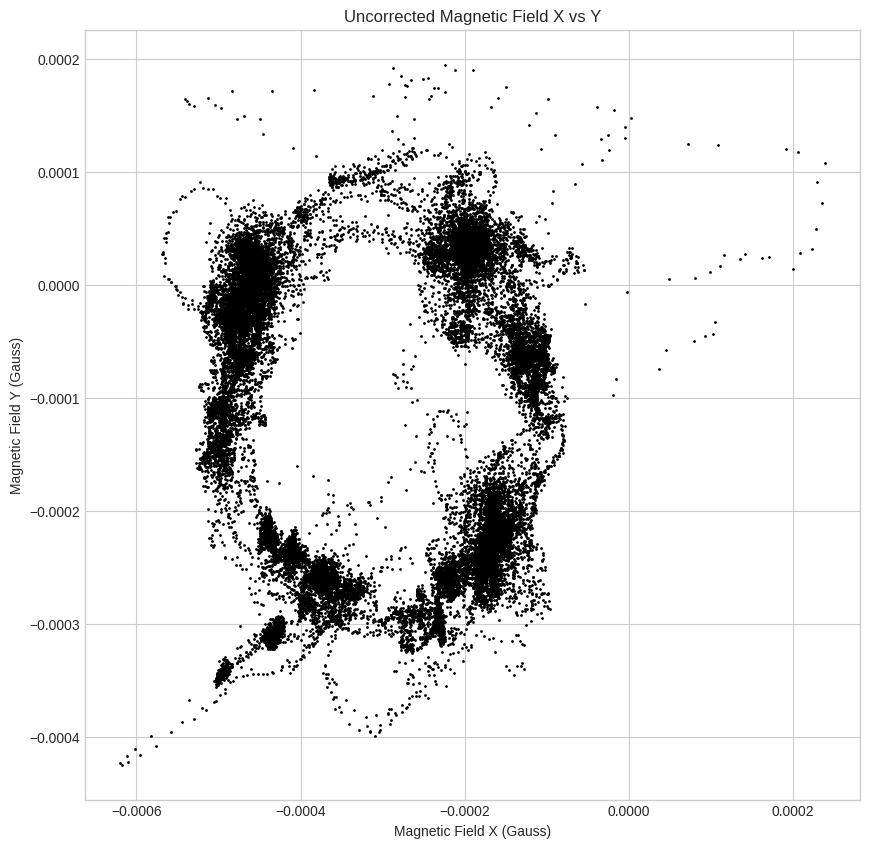

In [184]:
plt.figure(figsize=(10,10))
plt.plot(imu_df['MagField.magnetic_field.x'].to_numpy(), imu_df['MagField.magnetic_field.y'].to_numpy(), 'o', color='black', markersize=1)
plt.xlabel('Magnetic Field X (Gauss)')
plt.ylabel('Magnetic Field Y (Gauss)')
plt.title('Uncorrected Magnetic Field X vs Y')

In [185]:
#Fitting the ellipse to the collected data
#What do we get from fit_ellipse?
# a = [a, b, c, d, e, f]
# a*x^2 + b*x*y + c*y^2 + d*x + e*y + f = 0 which is the equation of an ellipse in conic form.
a = fit_ellipse(imu_df['MagField.magnetic_field.x'].to_numpy(),imu_df['MagField.magnetic_field.y'].to_numpy())
print(a)

[-6.81405263e-01  6.98247109e-02 -7.28567898e-01 -4.17976498e-04
 -1.41609789e-04 -4.76567284e-08]


In [186]:
#Calculate the center of the ellipse and the angle of rotation.
x0,y0 = ellipse_center(a)
axis_len = ellipse_axis_length(a)
psi = ellipse_angle_of_rotation(a)
print("Center: ", x0, y0)
print("Angle of rotation: ", psi)
print("Axis length: ", axis_len)

Center:  -0.0003124482413487556 -0.00011215591420027252
Angle of rotation:  0.48837107957301995
Axis length:  [0.00019645 0.00018504]


Text(0.5, 1.0, 'Corrected Magnetic Field X vs Y')

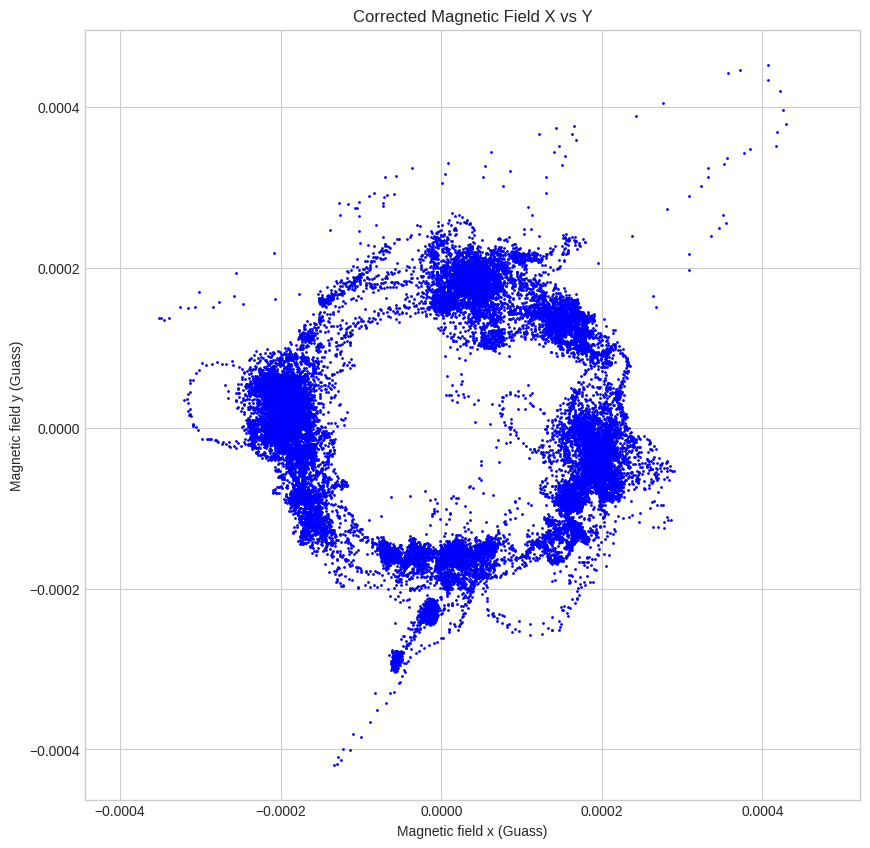

In [187]:
# Correcting the Magnetic Field Data
x_shift = imu_df['MagField.magnetic_field.x'] - x0
y_shift = imu_df['MagField.magnetic_field.y'] - y0

rot_matrix = np.array([[np.cos(psi), -np.sin(psi)], [np.sin(psi), np.cos(psi)]])
rotated = np.dot(rot_matrix, np.array([x_shift, y_shift]))
rotated_x = rotated[0]
rotated_y = rotated[1]

sigma = axis_len[0]/axis_len[1]
m_scale = np.array([[sigma, 0], [0, 1]])
scaled = np.dot(m_scale, np.array([rotated_x, rotated_y]))

plt.figure(figsize=(10,10))
plt.plot(scaled[0], scaled[1], 'o', color='blue', markersize=1)   
plt.axis('equal')
plt.xlabel('Magnetic field x (Guass)')
plt.ylabel('Magnetic field y (Guass)')
plt.title('Corrected Magnetic Field X vs Y')


/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


Text(0.5, 1.0, 'Comparison of Original and Corrected Magnetic Field')

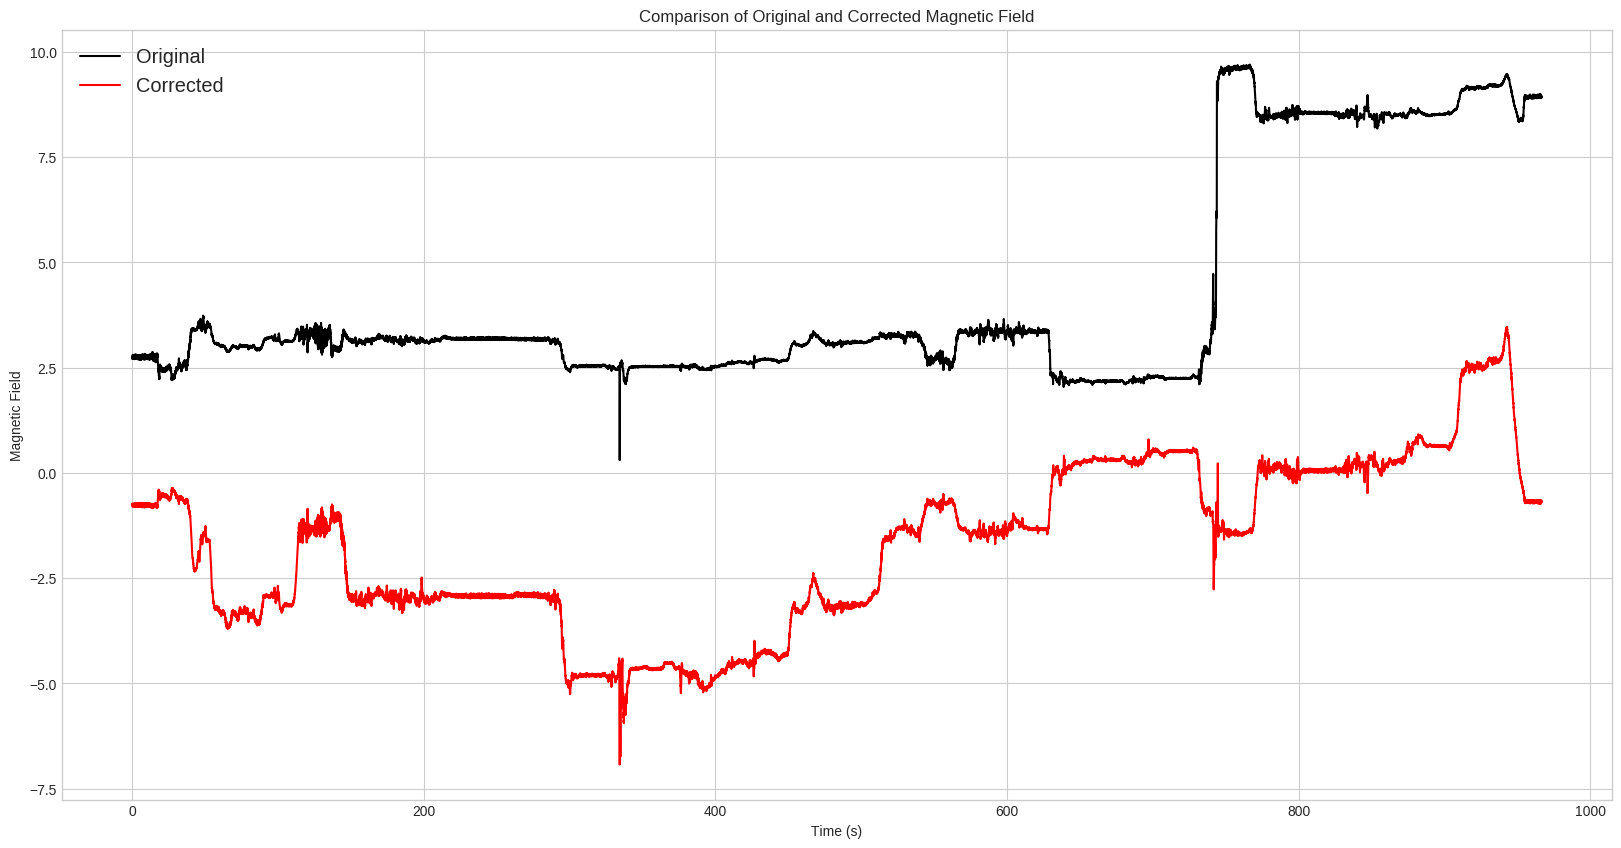

In [188]:
# Comparing the corrected data to the original data of the Magnetic Field.
# Why do we need to unwrap the data?
# The data is wrapped around the 0 degree mark.  
mag_original = np.unwrap(np.arctan2(-1*imu_df['MagField.magnetic_field.y'].to_numpy(), imu_df['MagField.magnetic_field.x'].to_numpy()))
mag_corrected = np.unwrap(np.arctan2(-1*scaled[1], scaled[0]))
plt.figure(figsize=(20,10))
plt.plot(time, mag_original, '-', color='black')
plt.plot(time, mag_corrected, '-', color='red')
legend = plt.legend(['Original', 'Corrected'], loc='upper left', shadow=True, fontsize='x-large')
plt.xlabel('Time (s)')
plt.ylabel('Magnetic Field')
plt.title('Comparison of Original and Corrected Magnetic Field')

Text(0.5, 1.0, 'Yaw angle vs Time')

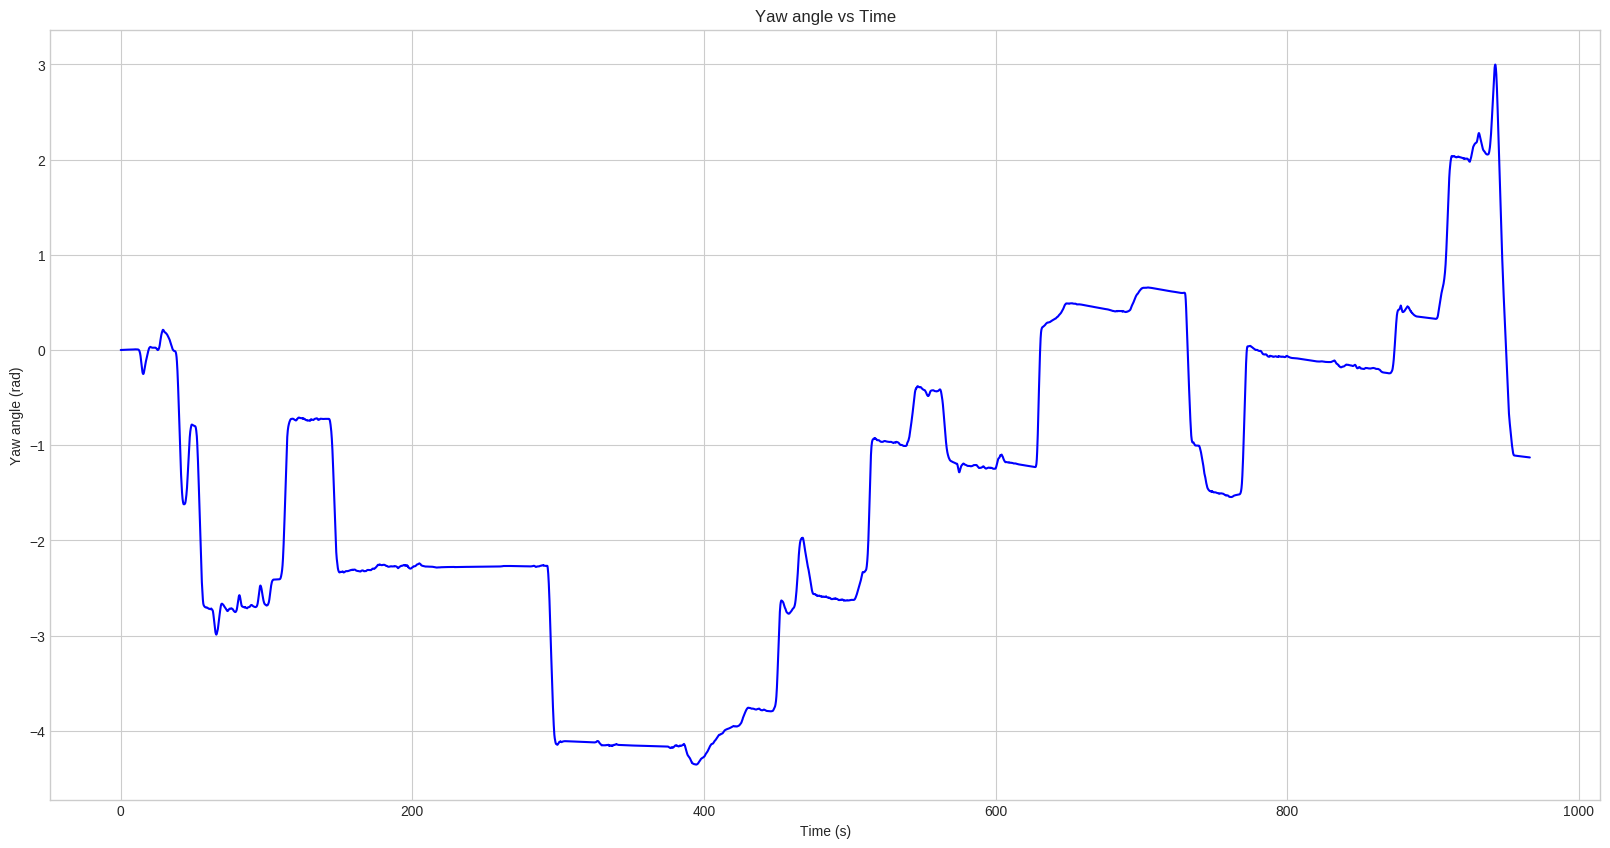

In [189]:
#Integrate Yaw rate
ang_z = np.matrix(imu_df['IMU.angular_velocity.z'].to_numpy())
yaw_ang = np.transpose(integrate.cumtrapz(ang_z, time, initial=0))
plt.figure(figsize=(20,10))
plt.plot(time, yaw_ang, '-', color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Yaw angle (rad)')
plt.title('Yaw angle vs Time')


Text(0.5, 1.0, 'Comparison of Magnetic Field and Yaw angle')

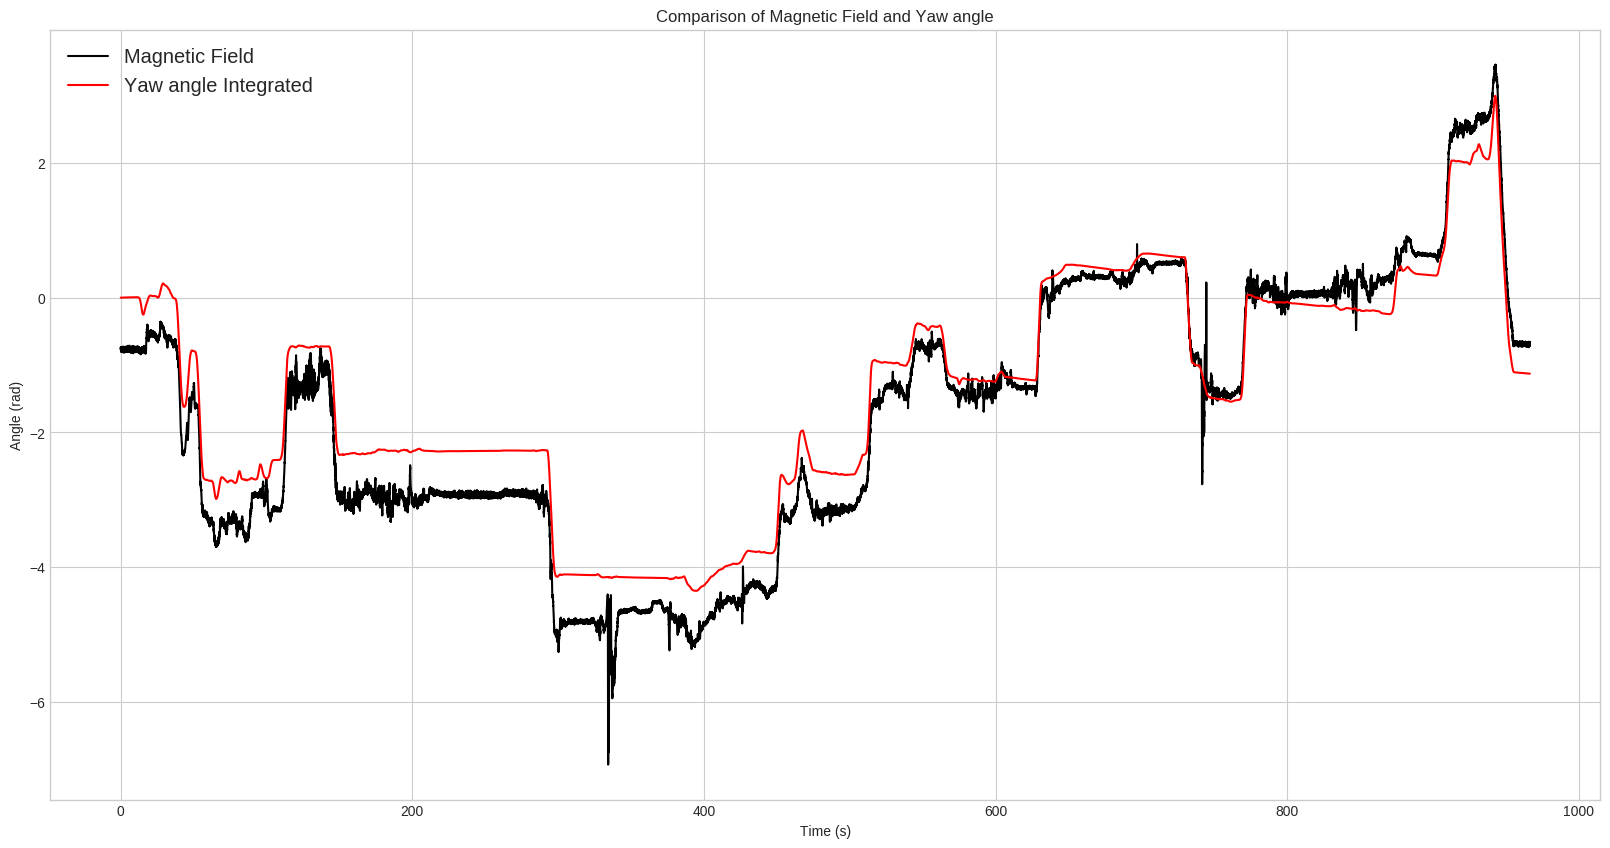

In [190]:
# Comparing the Magnetic Field Yaw and the Yaw angle
plt.figure(figsize=(20,10))
plt.plot(time, mag_corrected, '-', color='black')
plt.plot(time,yaw_ang, '-', color='red')
legend = plt.legend(['Magnetic Field', 'Yaw angle Integrated'], loc='upper left', shadow=True, fontsize='x-large')
plt.xlabel('Time (s)')
plt.ylabel('Angle (rad)')
plt.title('Comparison of Magnetic Field and Yaw angle')


Text(0.5, 1.0, 'Comparison of Low Pass, High Pass and Complementary Filter')

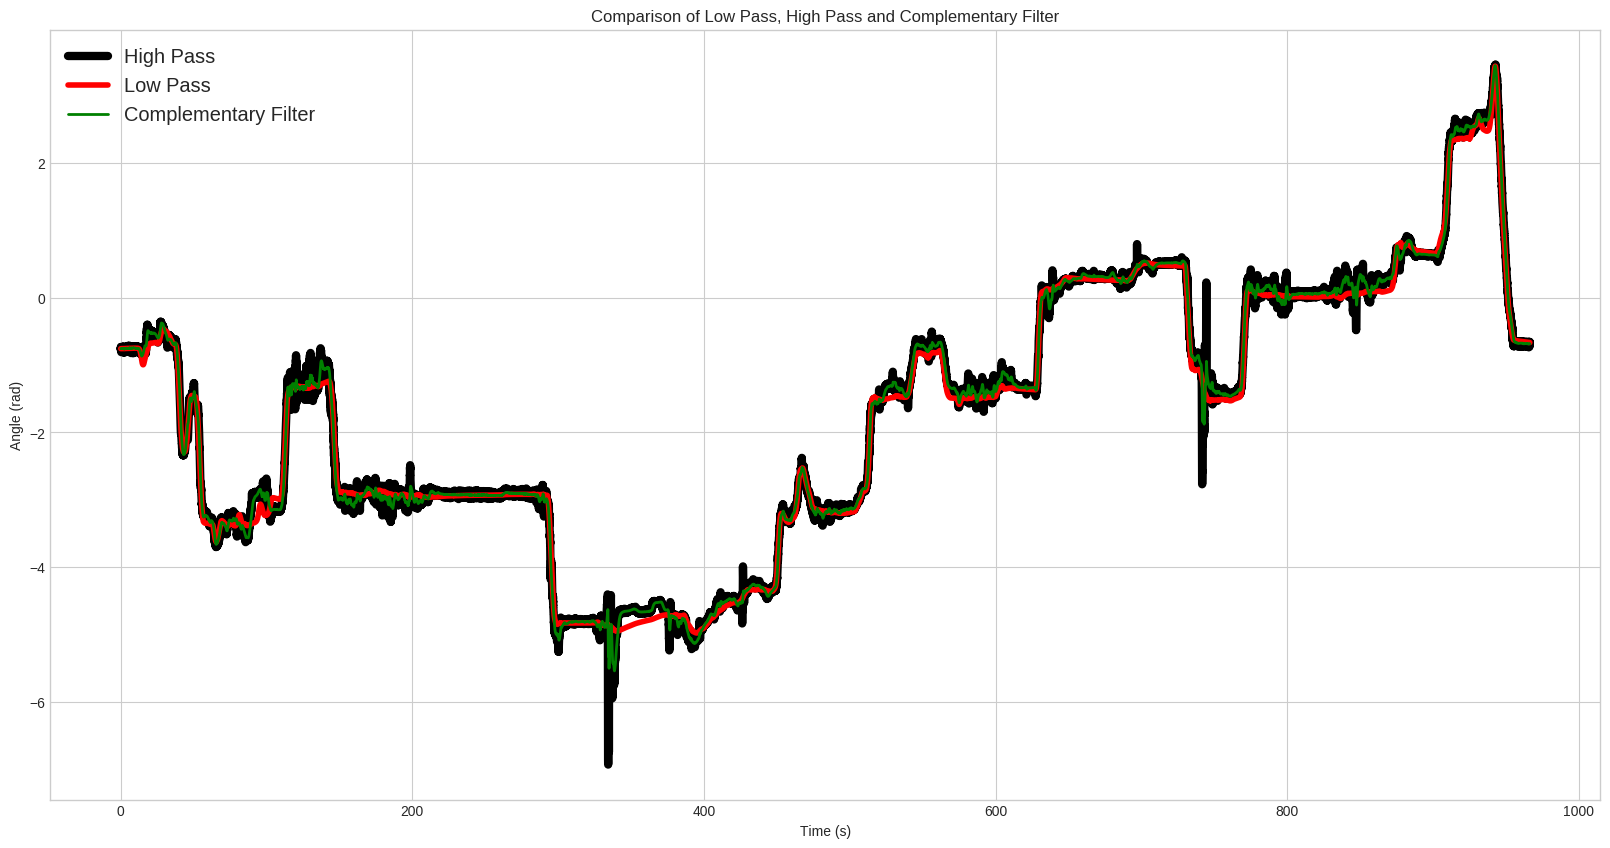

In [191]:
# Comparing Low Pass, high pass and complementary filter.
dt = np.diff(time)
dt = np.insert(dt, 0, 0)
ang_z = np.matrix(imu_df['IMU.angular_velocity.z'].to_numpy())


def complementary_filter(mag, ang_z, dt, alpha):
    yaw = np.zeros(len(mag))
    yaw[0] = np.mean(mag[0:100])
    for i in range(1, len(mag)):
        yaw[i] = alpha*(yaw[i-1] + ang_z[0,i]*dt[i]) + (1-alpha)*mag[i]
    return yaw

high_pass = complementary_filter(mag_corrected, ang_z, dt, 0.001)
low_pass = complementary_filter(mag_corrected, ang_z, dt, 0.999)
complementary_filter = complementary_filter(mag_corrected, ang_z, dt, 0.97)


plt.figure(figsize=(20,10))
plt.plot(time, high_pass, '-', color='black',linewidth=6)
plt.plot(time, low_pass, '-', color='red', linewidth=4)
plt.plot(time, complementary_filter, '-', color='green', linewidth=2)
legend = plt.legend(['High Pass', 'Low Pass', 'Complementary Filter'], loc='upper left', shadow=True, fontsize='x-large')
plt.xlabel('Time (s)')
plt.ylabel('Angle (rad)')
plt.title('Comparison of Low Pass, High Pass and Complementary Filter')



/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1390: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Cutoff frequency is:  1359 Hz


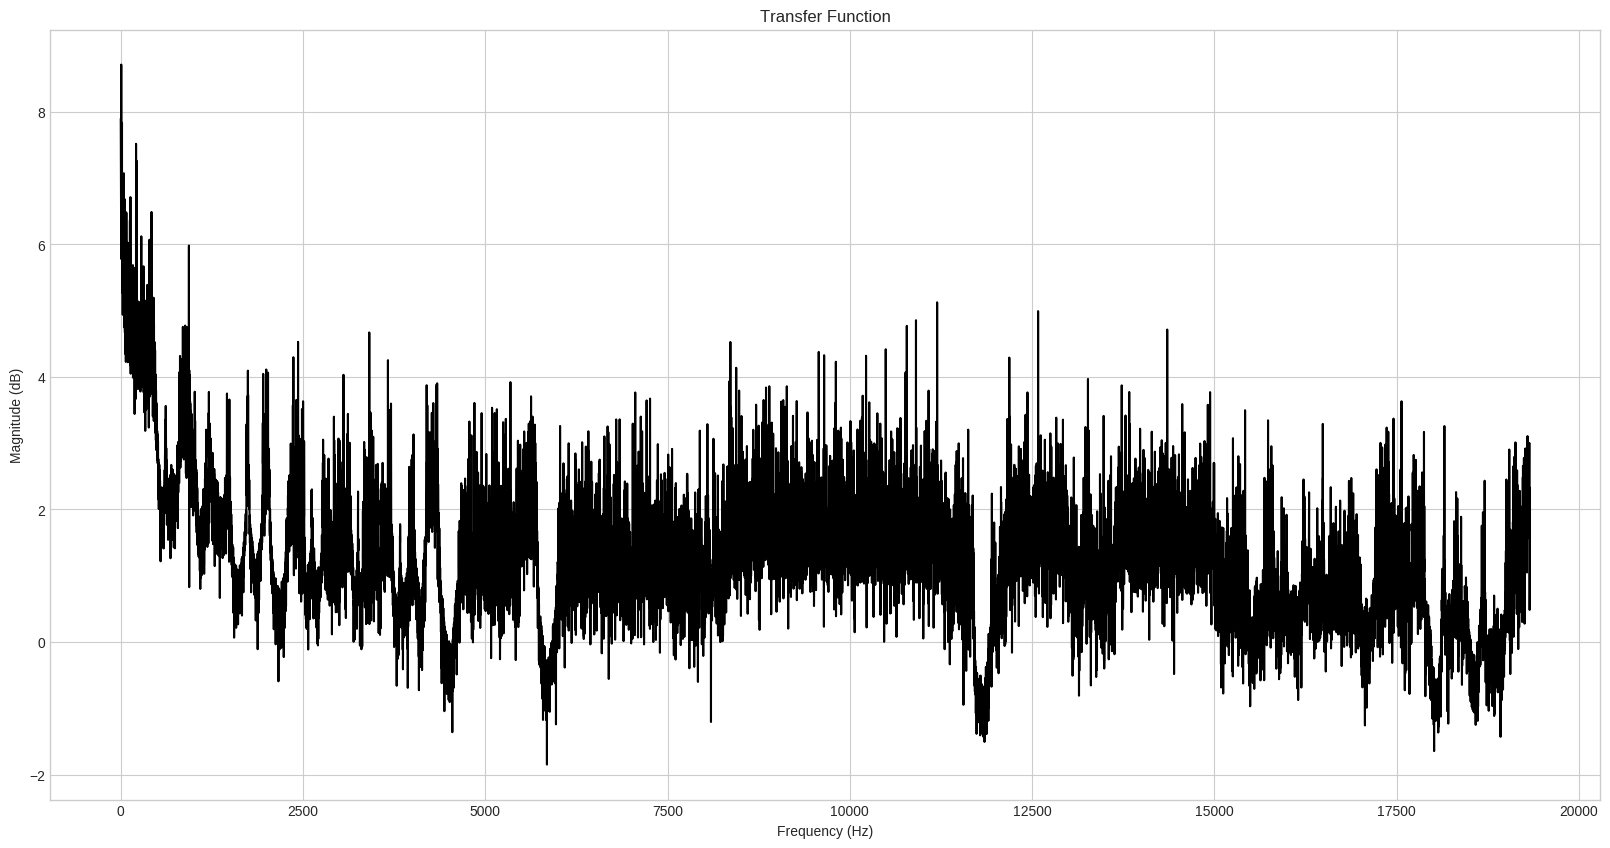

In [192]:
# Code to find the cutoff frequency
# The cutoff frequency is the frequency at which the magnitude of the transfer function is 1/sqrt(2)
# What is the transfer function?
# The transfer function is the ratio of the output to the input of a system.
# In this case, the input is the angular velocity and the output is the yaw angle.
# Estimate the transfer function using the FFT for the angular velocity and the yaw angle.
# The transfer function is the ratio of the FFT of the yaw angle to the FFT of the angular velocity.

# FFT of the angular velocity
ang_z = np.matrix(imu_df['IMU.angular_velocity.z'].to_numpy())
ang_z = np.transpose(ang_z)
ang_z_fft = np.fft.fft(ang_z)
ang_z_fft = ang_z_fft[0:int(len(ang_z_fft)/2)]
ang_z_fft = np.squeeze(np.asarray(ang_z_fft))

# FFT of the yaw angle
yaw_ang_fft = np.fft.fft(complementary_filter.copy())
yaw_ang_fft = yaw_ang_fft[0:int(len(yaw_ang_fft)/2)]
yaw_ang_fft = np.abs(yaw_ang_fft)


# Transfer function
# Ignore divide by zero error
np.seterr(divide='ignore', invalid='ignore')
transfer_function = np.divide(yaw_ang_fft, ang_z_fft)
transfer_function = np.log10(transfer_function)

# Plot the transfer function
plt.figure(figsize=(20,10))
plt.plot(transfer_function, '-', color='black')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.title('Transfer Function')

# Find the cutoff frequency
# The cutoff frequency is the frequency at which the magnitude of the transfer function is 1/sqrt(2)
cutoff_freq = np.where(transfer_function < (1/np.sqrt(2)))

cutoff_freq = cutoff_freq[0][0]
print("Cutoff frequency is: ", cutoff_freq, "Hz")





Text(0.5, 1.0, 'Comparison of Complementary Filter and Yaw angle')

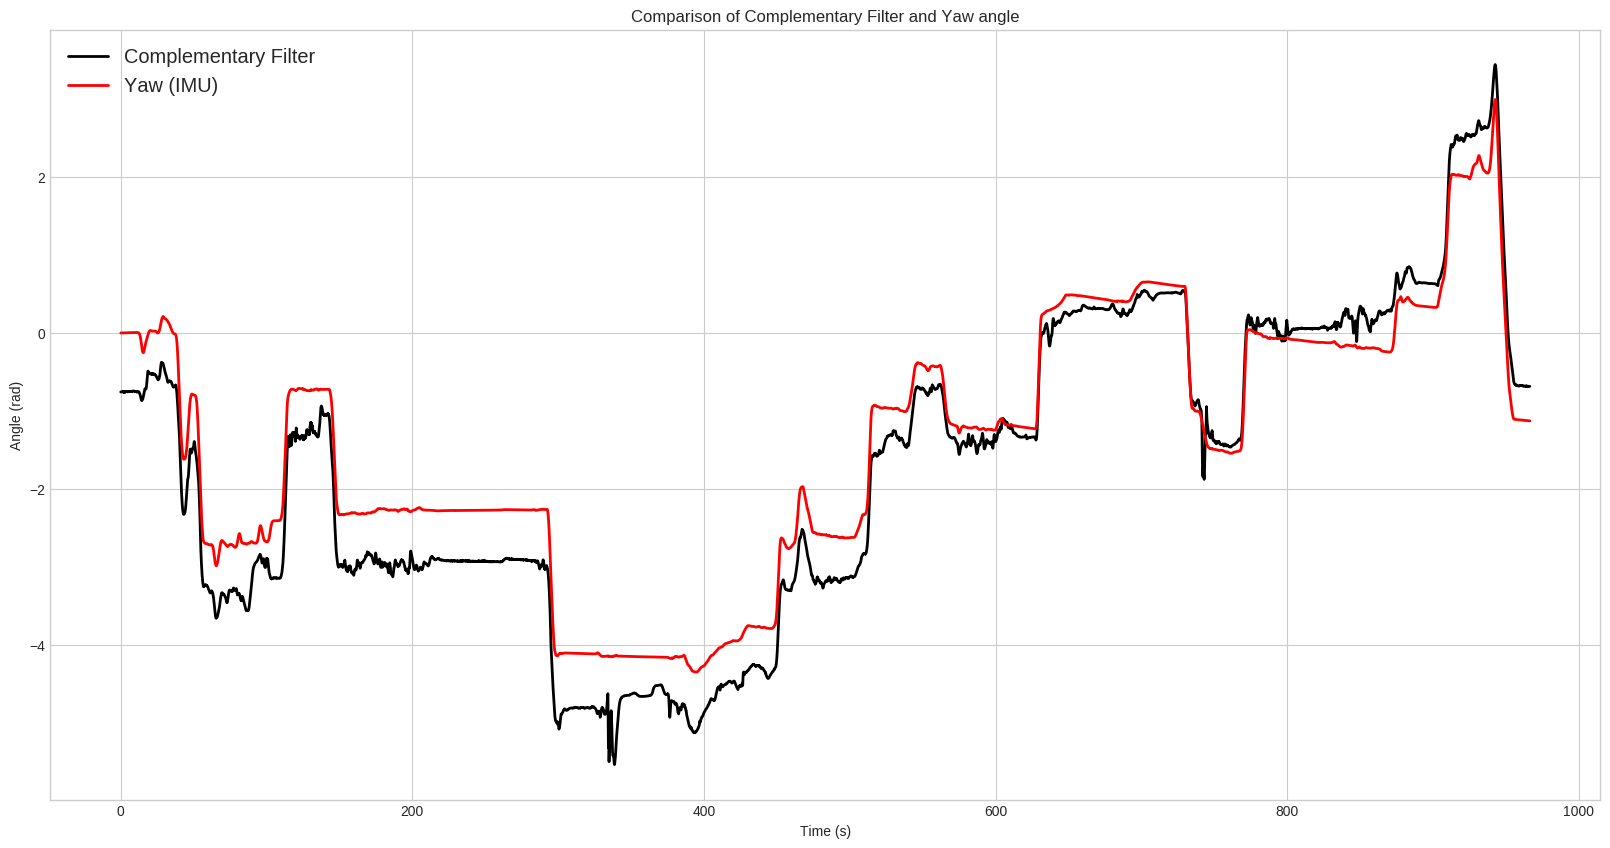

In [193]:
# Comparing the Complementary Filter with the Yaw angle
plt.figure(figsize=(20,10))
plt.plot(time, complementary_filter, '-', color='black', linewidth=2)
plt.plot(time, yaw_ang, '-', color='red', linewidth=2)
legend = plt.legend(['Complementary Filter', 'Yaw (IMU)'], loc='upper left', shadow=True, fontsize='x-large')
plt.xlabel('Time (s)')
plt.ylabel('Angle (rad)')
plt.title('Comparison of Complementary Filter and Yaw angle')


Text(0.5, 1.0, 'Velocity vs Time for GPS')

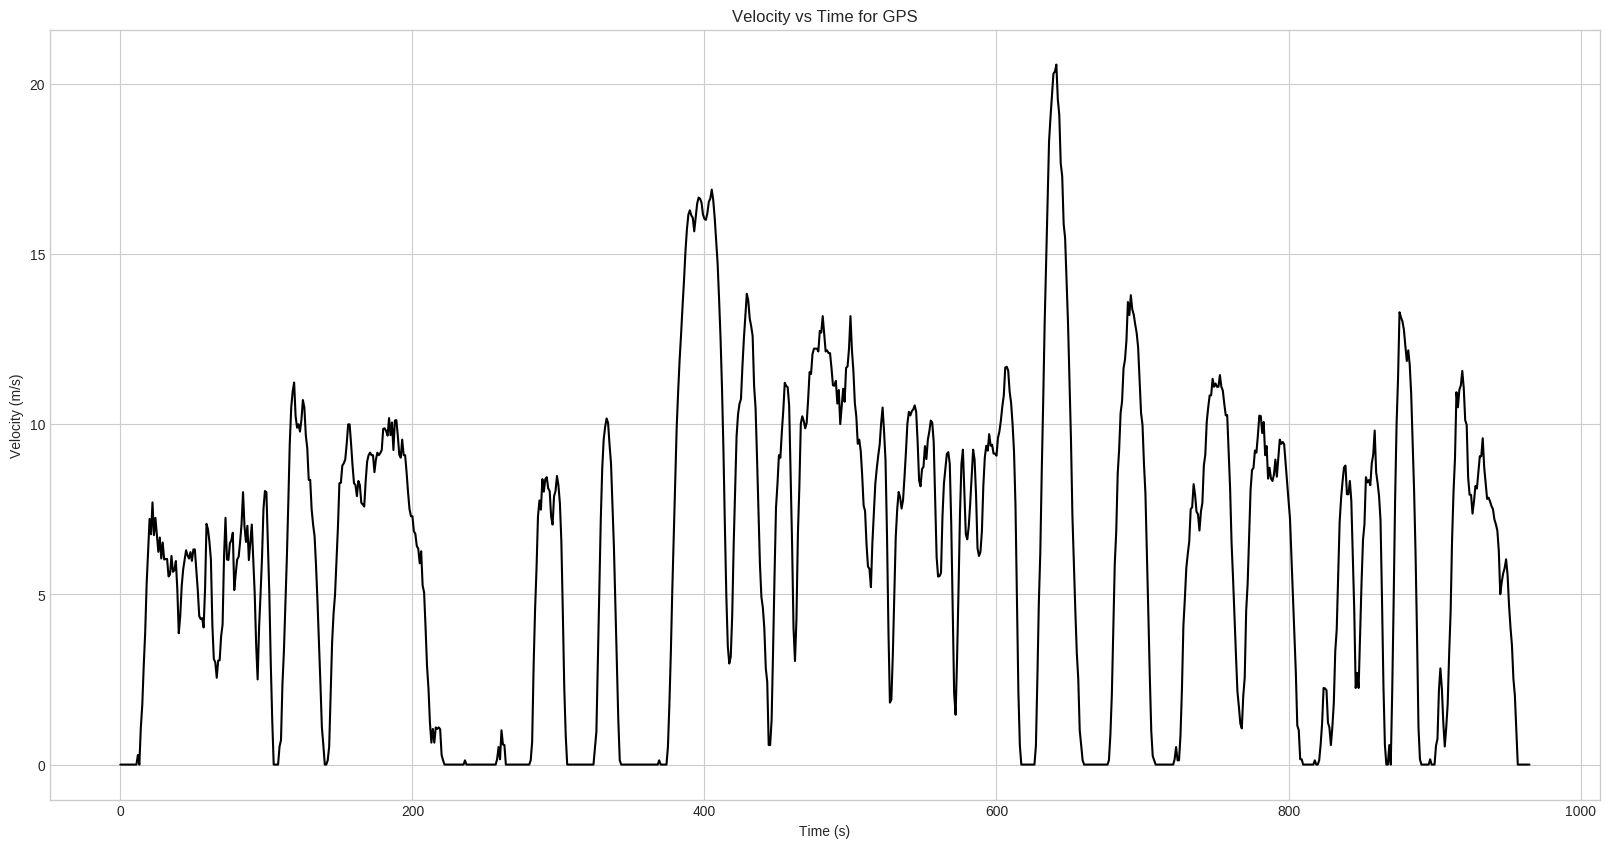

In [194]:
# Getting the GPS Veocity
utm_east = gps_df['UTM_easting'].to_numpy()
utm_north = gps_df['UTM_northing'].to_numpy()
utm_east = utm_east - utm_east[0]
utm_north = utm_north - utm_north[0]

time_secs_gps = gps_df['Header.stamp.secs'].to_numpy()
time_nsecs_gps = gps_df['Header.stamp.nsecs'].to_numpy()
time_gps = time_secs_gps + time_nsecs_gps*1e-9
time_gps = time_gps - time_gps[0]

dt_gps = np.diff(time_gps)

# Calculate the distance between each point
dist = np.zeros(len(utm_east))
for i in range(1, len(utm_east)):
    dist[i] = dist[i-1] + np.sqrt((utm_east[i]-utm_east[i-1])**2 + (utm_north[i]-utm_north[i-1])**2)


# Calculate the velocity
vel = np.zeros(len(utm_east))
for i in range(1, len(utm_east)):
    vel[i] = (dist[i] - dist[i-1])/dt_gps[i-1]


plt.figure(figsize=(20,10))
plt.plot(time_gps, vel, '-', color='black')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.title('Velocity vs Time for GPS')


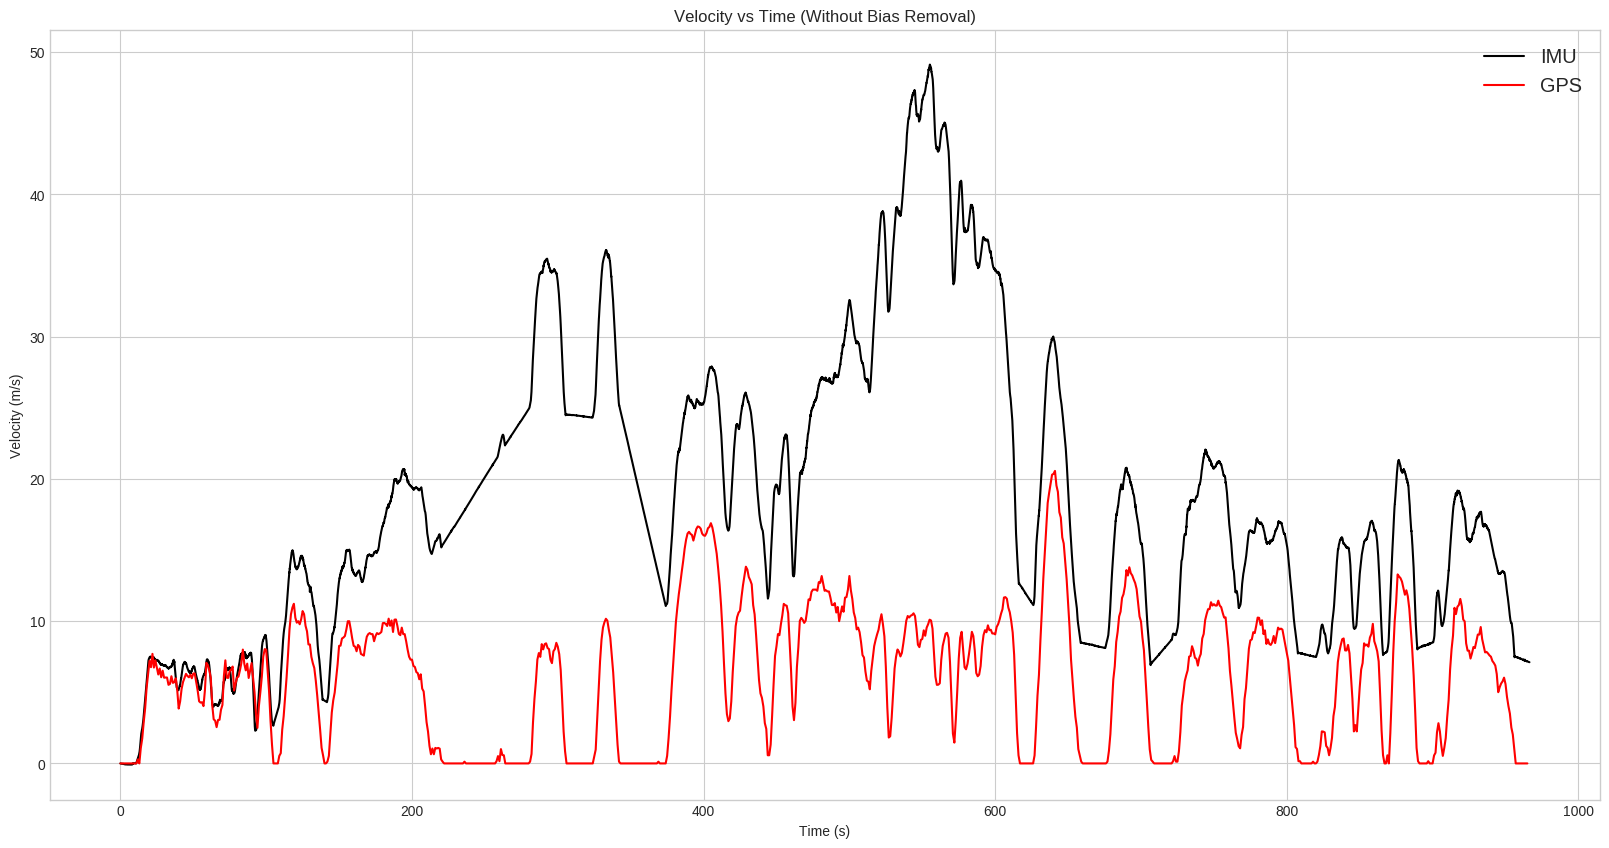

In [195]:
# Getting the forward velocity from the IMU
acc_x = imu_df['IMU.linear_acceleration.x'].to_numpy()
acc_x = acc_x - np.mean(acc_x[0:420])
ang_y = np.matrix(imu_df['IMU.angular_velocity.y'].to_numpy())
pitch_ang = -1 * integrate.cumulative_trapezoid(ang_y, time, initial=0)

# dt
dt = np.diff(time)
dt = np.append(dt, dt[-1])

# Integrate the acceleration to get the velocity
vel_x = np.transpose(integrate.cumulative_trapezoid(acc_x, time, initial=0))   -  np.multiply(np.sin(pitch_ang[0])*10, dt) # Removing the gravity component
#Plots  
plt.figure(figsize=(20,10))
plt.plot(time, np.transpose(vel_x), '-', color='black')
plt.plot(time_gps, vel, '-', color='red')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.title('Velocity vs Time (Without Bias Removal)')
legend = plt.legend(['IMU', 'GPS'], loc='upper right', shadow=True, fontsize='x-large')

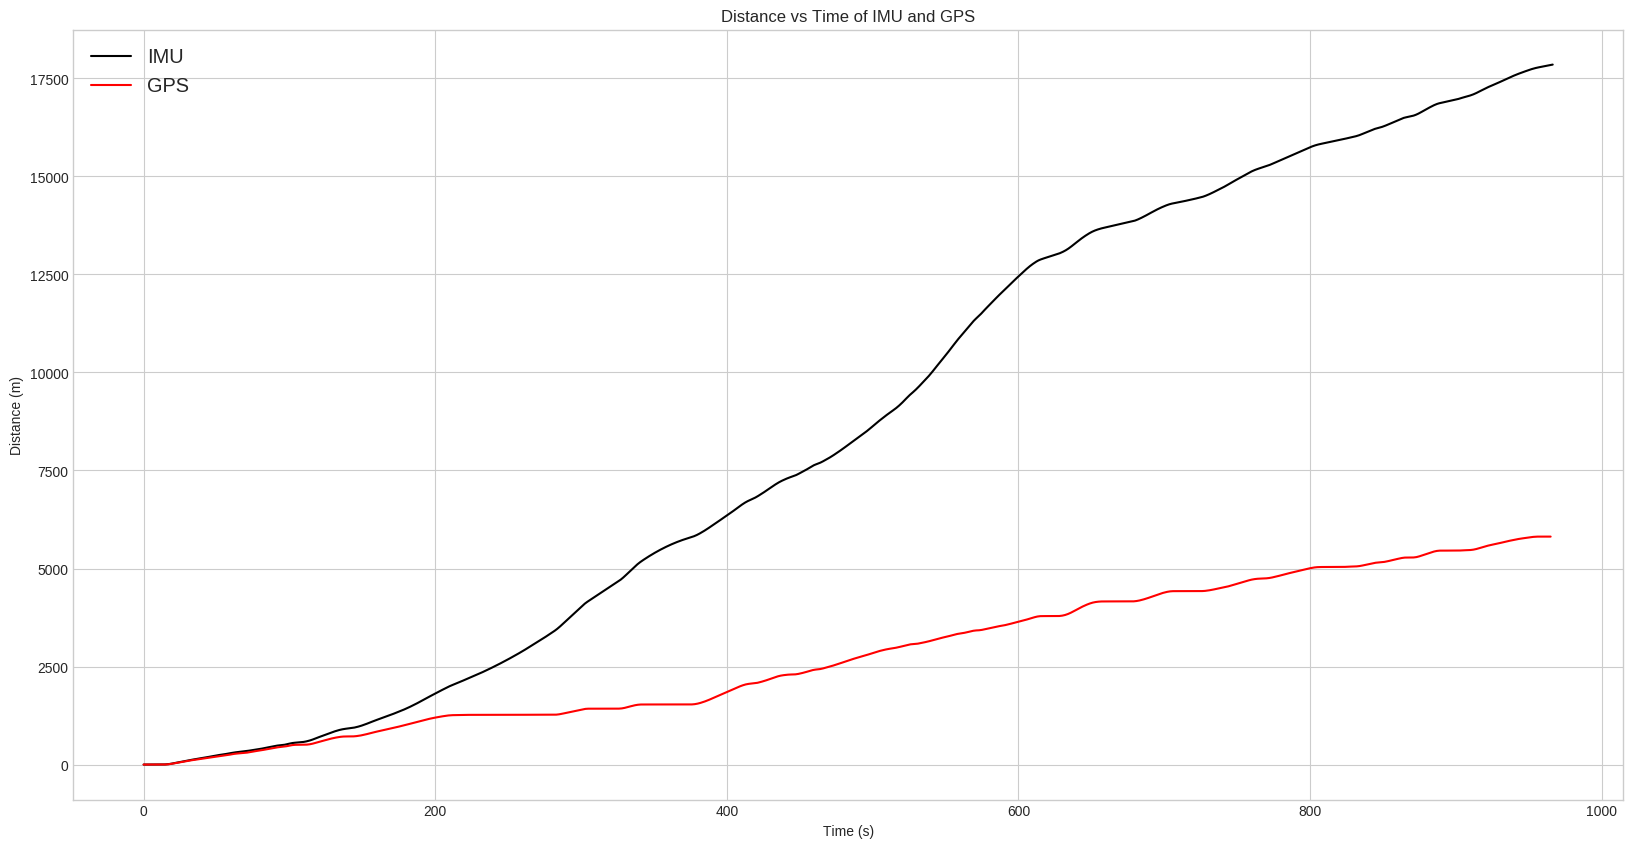

In [196]:
#Integrating the forward velocity
dist_x = integrate.cumtrapz(vel_x, time, initial=0)
dist_x_gps = integrate.cumtrapz(vel, time_gps, initial=0)

#Plots
plt.figure(figsize=(20,10))
plt.plot(time, np.transpose(dist_x), '-', color='black')
plt.plot(time_gps, dist_x_gps, '-', color='red')
plt.xlabel('Time (s)')
plt.ylabel('Distance (m)')
plt.title('Distance vs Time of IMU and GPS')
legend = plt.legend(['IMU', 'GPS'], loc='upper left', shadow=True, fontsize='x-large')

In [197]:
read = bagreader('the_journey_2022-10-22-17-34-28.bag')
read_stats = read.message_by_topic('/imu')
gps_data = read.message_by_topic('/gps')
gps_df = pd.read_csv(gps_data)
imu_df = pd.read_csv(read_stats)

[INFO]  Data folder the_journey_2022-10-22-17-34-28 already exists. Not creating.


/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


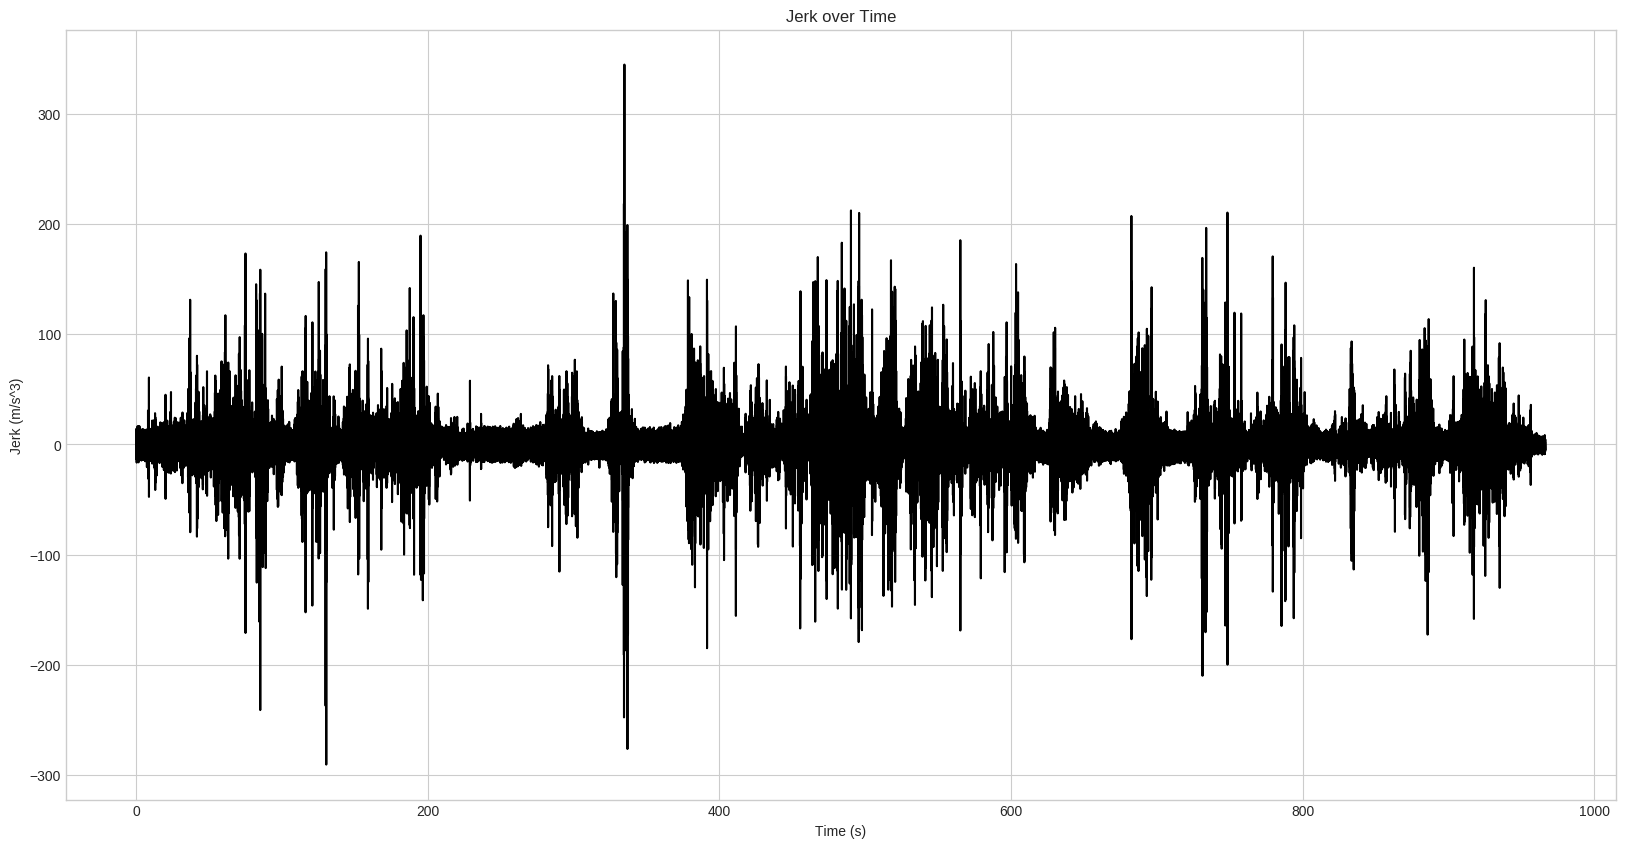

[40, 520, 4200, 5600, 8880, 9480, 10560, 12240, 13720, 14800, 24680, 26400, 28360, 32400, 32760, 34680, 34800, 35640, 35920]
[440, 520, 4320, 5640, 9400, 10280, 11200, 12960, 14720, 14960, 25040, 27040, 28840, 32680, 32800, 34720, 34800, 35840, 36000]


In [198]:
# Get the jerk in x direction
acc_x_main = imu_df['IMU.linear_acceleration.x'].to_numpy()
acc_x = acc_x_main.copy()
jerk_x = np.diff(acc_x, n=1, axis=0)/np.diff(time, n=1, axis=0)
#Plots
plt.figure(figsize=(20,10))
plt.plot(time[0:-1], jerk_x, '-', color='black')
plt.xlabel('Time (s)')
plt.ylabel('Jerk (m/s^3)')
plt.title('Jerk over Time')
plt.show()

#Get indexes of the stationary periods
zero_vel = []
final = []
for i in range(1, len(vel)):
    if np.abs(vel[i]) <=0.1:
        zero_vel.append(i)
    else:
        if len(zero_vel) > 0:
            final.append(zero_vel)
            zero_vel = []


# Getting the start and end times of the zero velocity
start_time = []
end_time = []
for i in range(len(final)):
    start_time.append(time_gps[final[i][0]])
    end_time.append(time_gps[final[i][-1]])

# Getting the corresponding IMU time steps
start_time_imu = []
end_time_imu = []
for i in range(len(start_time)):
    start_time_imu.append(np.argmin(np.abs(time - start_time[i])))
    end_time_imu.append(np.argmin(np.abs(time - end_time[i])))
print(start_time_imu)
print(end_time_imu)




In [199]:
# Get the acc_x at start time and end time
acc_x_start = []
acc_x_end = []
for i in range(len(start_time_imu)):
    acc_x_start.append(acc_x[start_time_imu[i]])
    acc_x_end.append(acc_x[end_time_imu[i]])

# The acceleration values between the start and end times of the stationary periods
list_of_acc = []
non_zero_acc = []
start = False
for i in range(len(acc_x_start)):
    for j in range(len(acc_x)):
        if acc_x[j] == acc_x_start[i] or start == True:
            start = True
            non_zero_acc.append(acc_x[j])
            if acc_x[j] == acc_x_end[i]:
                start = False
                list_of_acc.append(non_zero_acc)
                non_zero_acc = []
                break

# Finding the mean of all the values in list_of_acc
mean_acc = []
for i in range(len(list_of_acc)):
    mean_acc.append(np.mean(list_of_acc[i]))
print(mean_acc)
print(len(mean_acc))


[-0.5944488778054864, 0.074, -0.3316284246575342, -0.6799961513790892, -0.5723194444444445, -0.772891975308642, -0.2207538461538462, -0.5689572963059994, -0.57743778207608, -0.48829759704251385, -0.7511849315068493, -0.5587294117647059, -0.6805641891891892, -0.5340429624879769, -0.6083666666666666, -0.6108297872340426, 2.269, -0.4954867300951427, -0.12139703459637564]
19


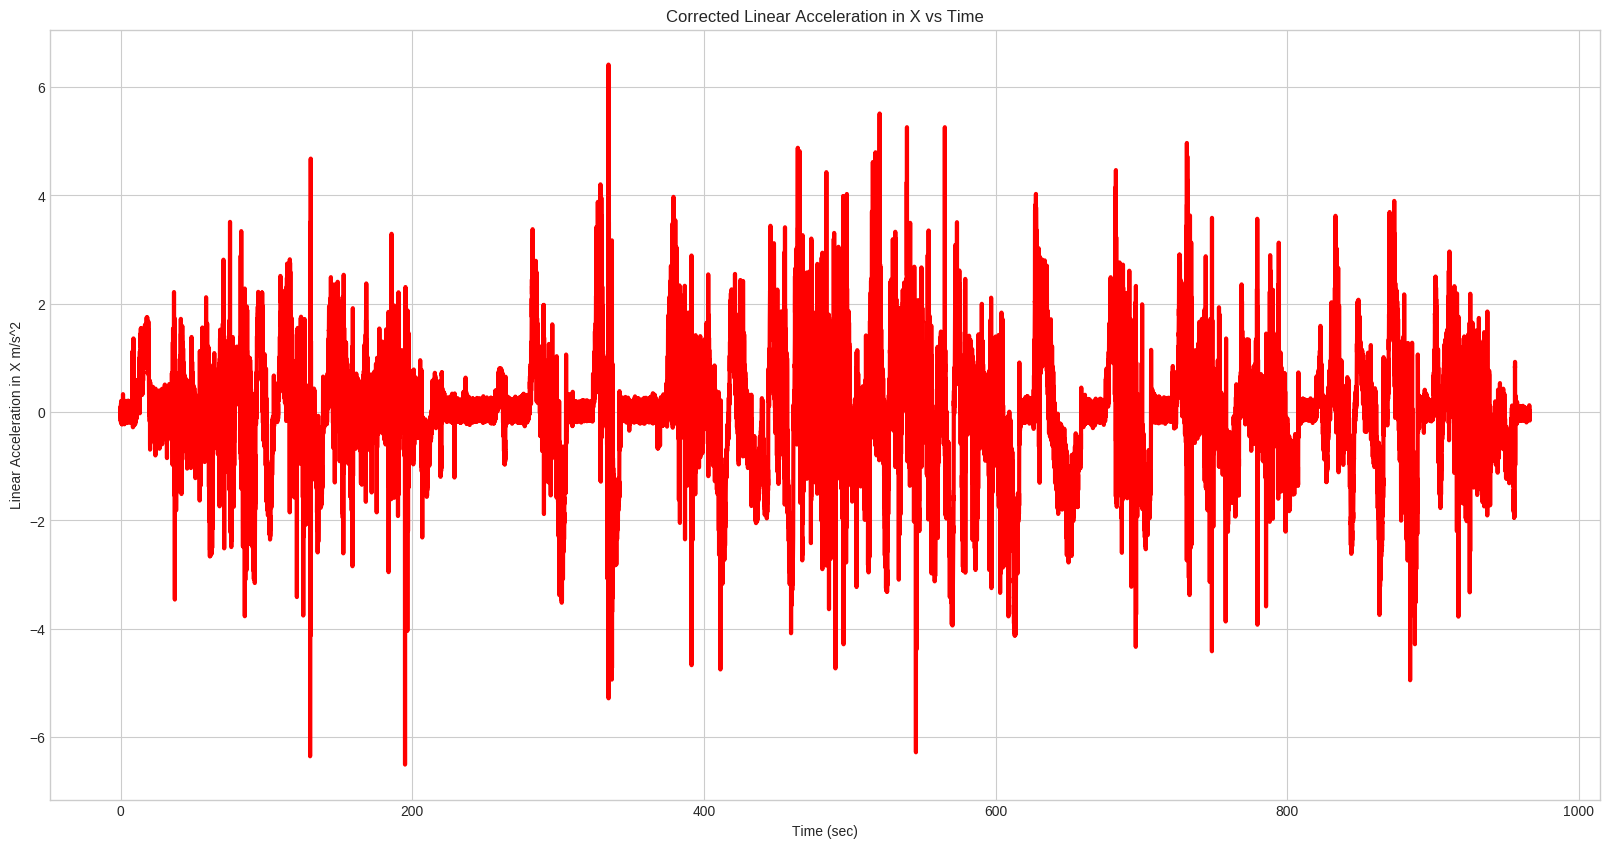

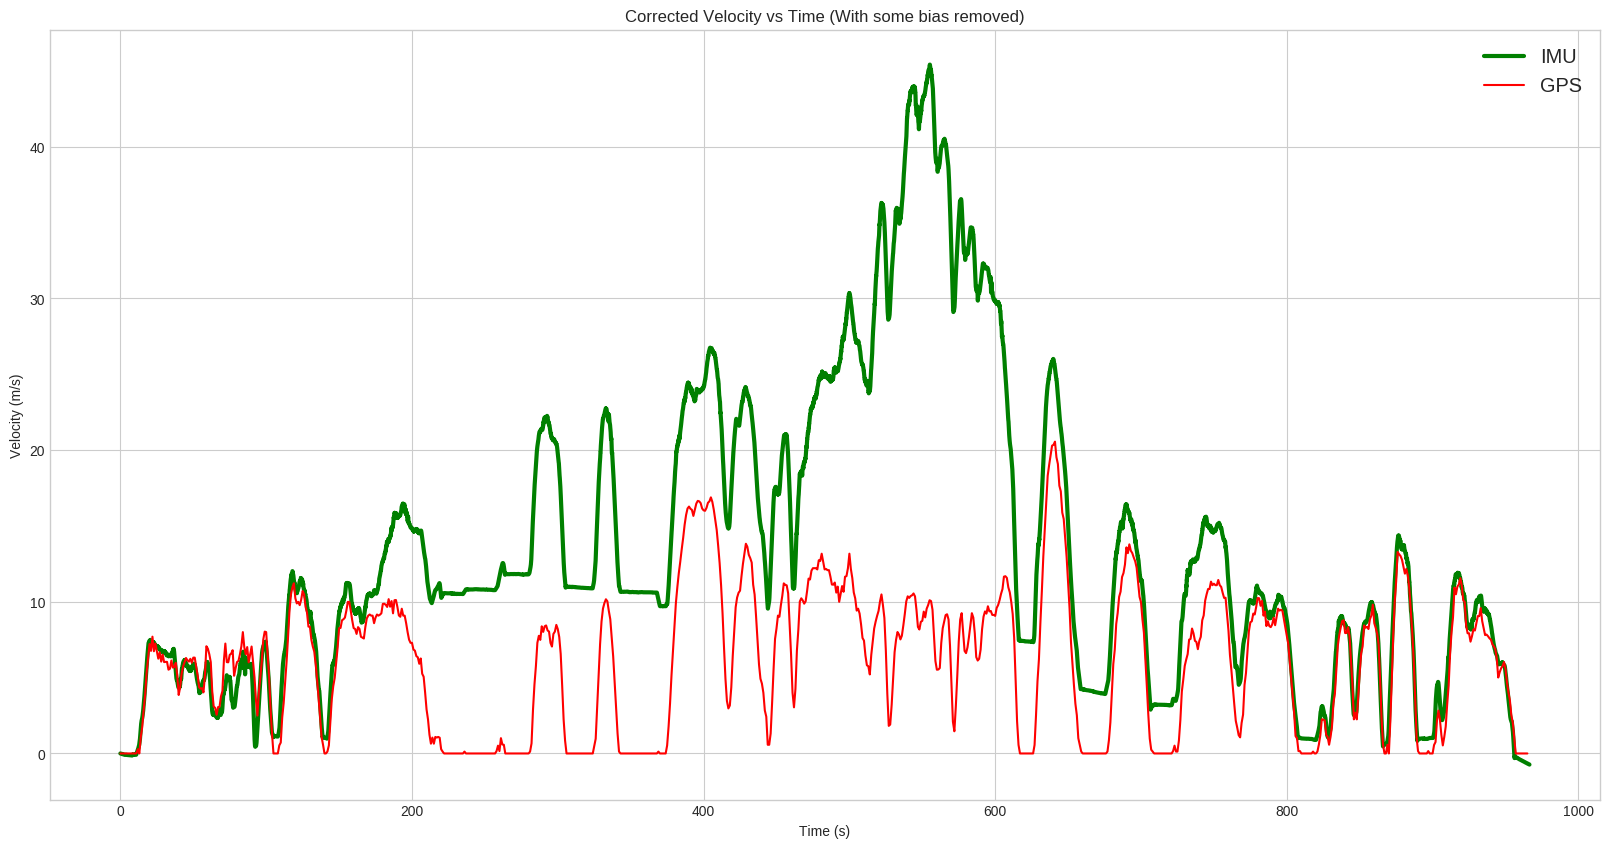

In [208]:
acc_x_main = imu_df['IMU.linear_acceleration.x'].to_numpy()
acc_x = acc_x_main.copy()
acc_x = acc_x - np.mean(acc_x[0:445])
for i in range(1, len(start_time_imu)):
    s = start_time_imu[i]
    e = end_time_imu[i]
    if s<e:
        # print(len(acc_x[s:e]))
        m = np.nanmean(acc_x[s:e], axis=0)
        # print(m)
        acc_x[s:e] -= m

plt.figure(figsize=(20,10))
plt.plot(time, acc_x, '-', color='red', linewidth=3)
plt.xlabel('Time (sec)')
plt.ylabel('Linear Acceleration in X m/s^2')
plt.title('Corrected Linear Acceleration in X vs Time')

# Integrate to get velocity
vel_x = np.transpose(integrate.cumulative_trapezoid(acc_x, time, initial=0)) - np.sin(pitch_ang[0])*10
#Plots
plt.figure(figsize=(20,10))
plt.plot(time, np.transpose(vel_x), '-', color='green', linewidth=3)
plt.plot(time_gps, vel, '-', color='red')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.title('Corrected Velocity vs Time (With some bias removed)')
legend = plt.legend(['IMU', 'GPS'], loc='upper right', shadow=True, fontsize='x-large')




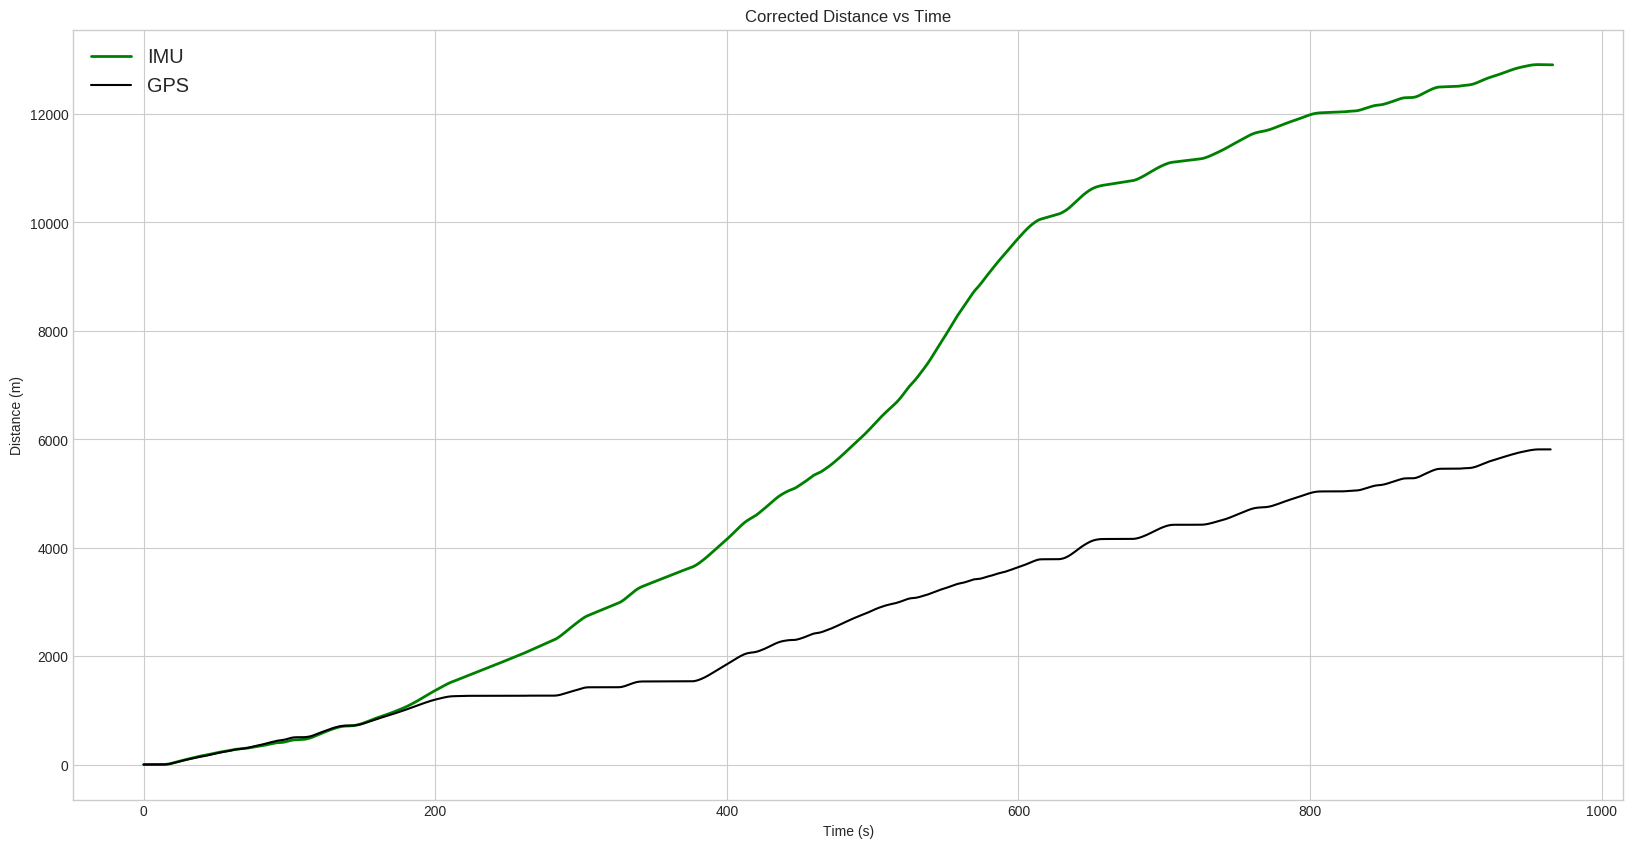

In [209]:
# Integrate to get distance.
dist_x = integrate.cumtrapz(vel_x, time, initial=0)
dist_x_gps = integrate.cumtrapz(vel, time_gps, initial=0)
#Plots
plt.figure(figsize=(20,10))
plt.plot(time, np.transpose(dist_x), '-', color='green', linewidth = 2)
plt.plot(time_gps, dist_x_gps, '-', color='black')
plt.xlabel('Time (s)')
plt.ylabel('Distance (m)')
plt.title('Corrected Distance vs Time')
legend = plt.legend(['IMU', 'GPS'], loc='upper left', shadow=True, fontsize='x-large')


In [210]:
# Getting the UTM coordinates

utm_east = gps_df['UTM_easting'].to_numpy() 
utm_north = gps_df['UTM_northing'].to_numpy()
utm_north = utm_north - utm_north[0]
utm_east = utm_east - utm_east[0] 

heading_ang = complementary_filter.copy()
heading_ang = heading_ang - heading_ang[0]

# Multiply velocity with he heading angle to get the velocity in the x and y directions
velocity_x = vel_x*np.cos(heading_ang) 
velocity_y = vel_x*np.sin(heading_ang) 




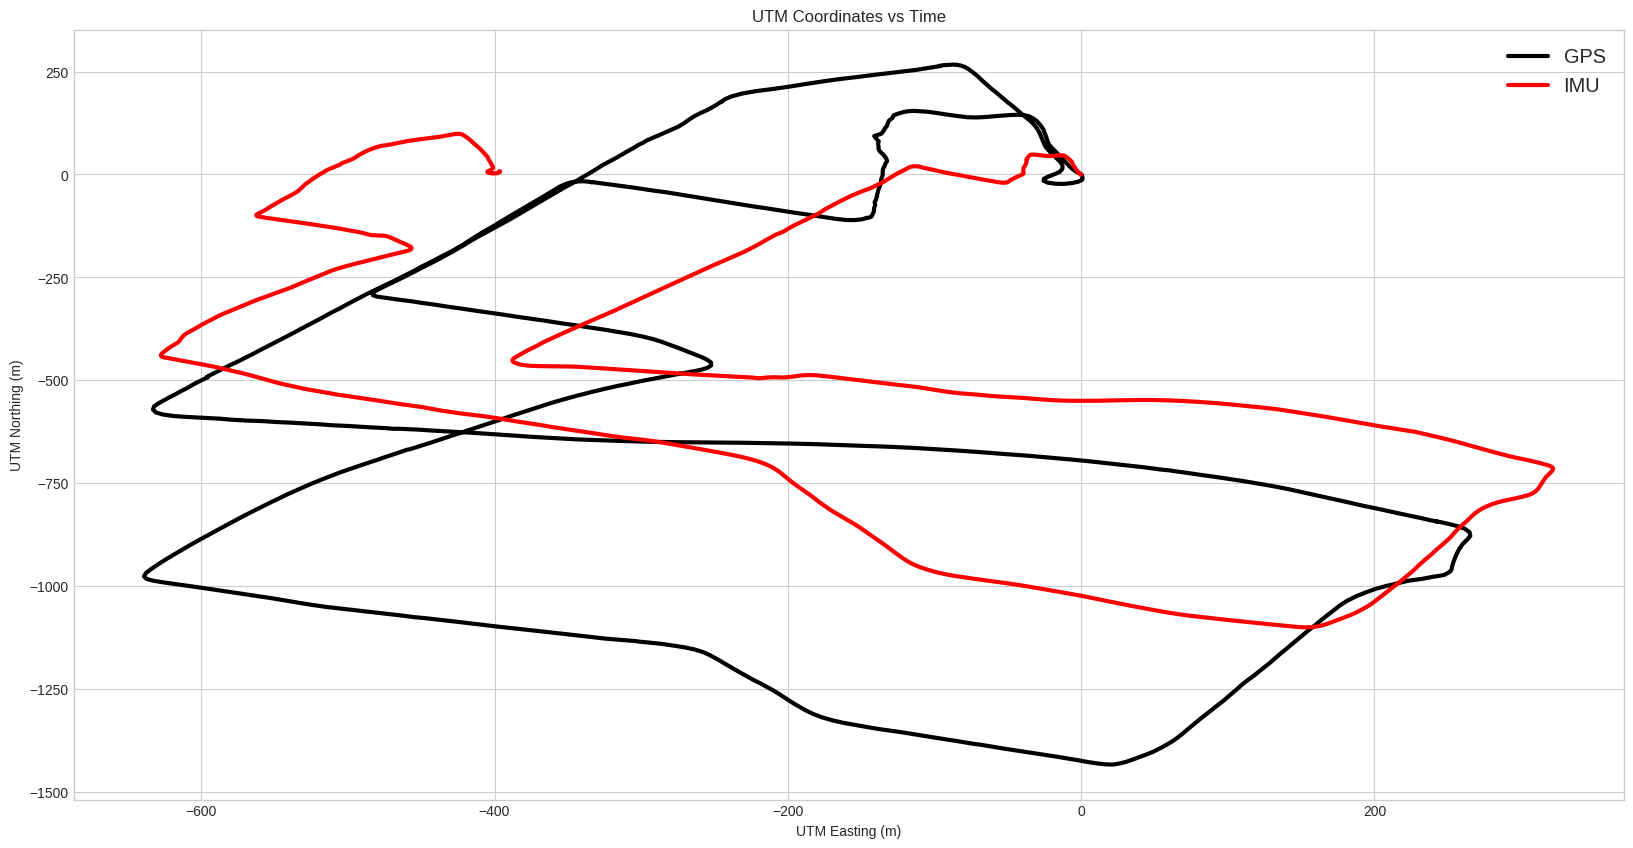

In [211]:
# How to dist_x and dist_y at a certain angle
# Get the angle
angle = 20
# Get the distance in x and y directions
dist_x = integrate.cumtrapz(velocity_x, time, initial=0) *0.3
dist_y = integrate.cumtrapz(velocity_y, time, initial=0)*0.3
# Get the distance in x and y directions at a certain angle
dist_x_angle = dist_x*np.cos(angle) - dist_y*np.sin(angle)
dist_y_angle = dist_x*np.sin(angle) + dist_y*np.cos(angle)


# Get the UTM coordinates
plt.figure(figsize=(20,10))
plt.plot(utm_east, utm_north, '-', color='black', linewidth=3)
plt.plot(-1*dist_x_angle, dist_y_angle, '-', color='red', linewidth=3)
plt.xlabel('UTM Easting (m)')
plt.ylabel('UTM Northing (m)')
plt.title('UTM Coordinates vs Time')
legend = plt.legend(['GPS', 'IMU'], loc='upper right', shadow=True, fontsize='x-large')


(38658,)


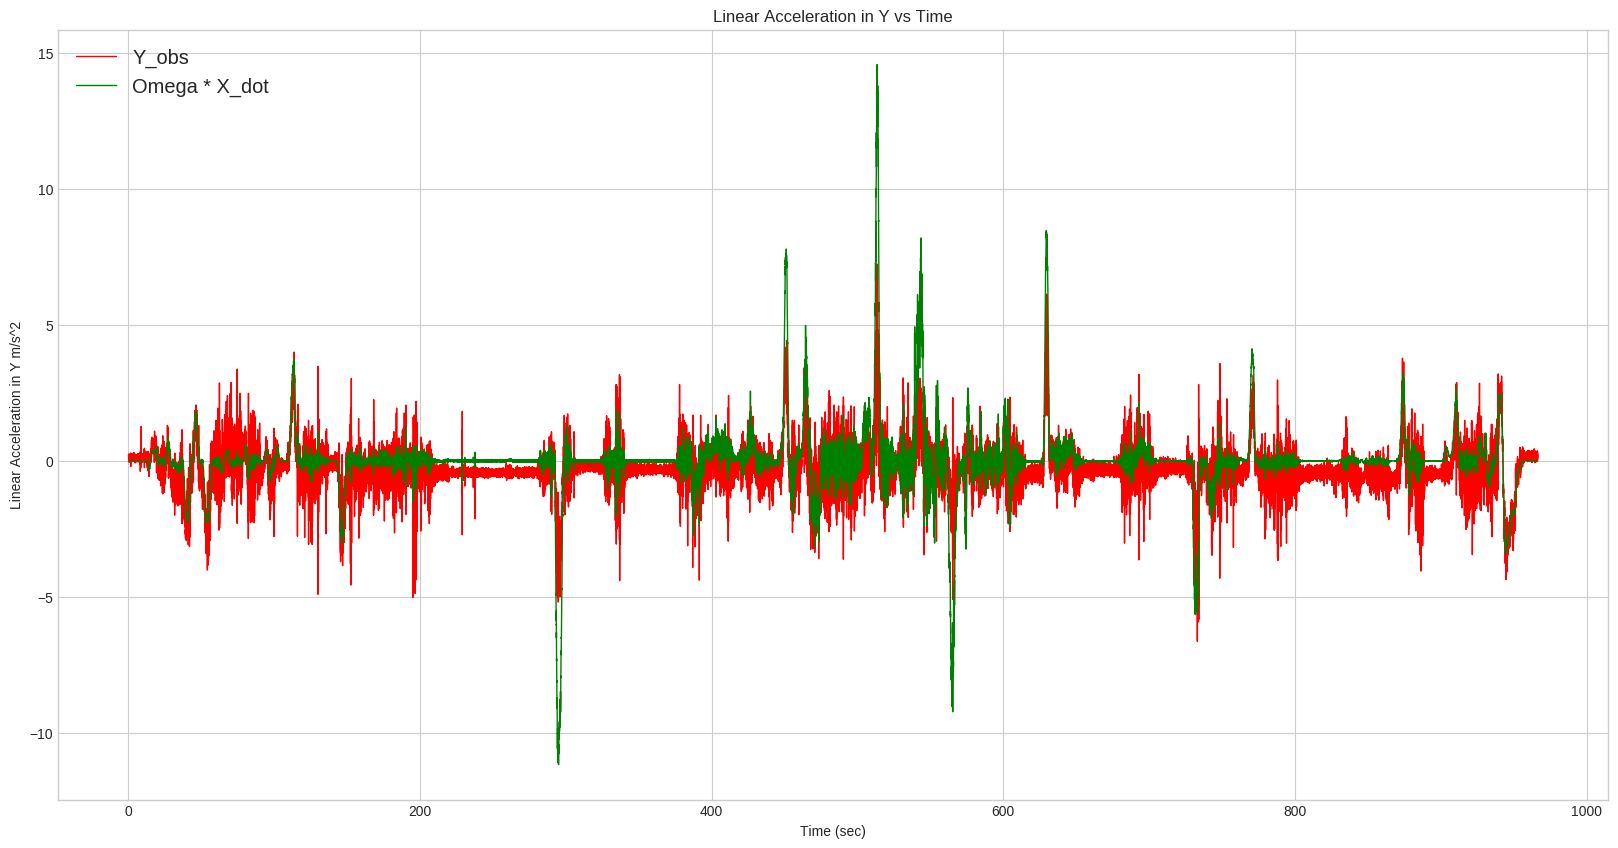

In [212]:
ang_z = imu_df['IMU.angular_velocity.z'].to_numpy()
velocity_x = np.multiply(vel_x,ang_z)
print(velocity_x.shape)

acc_y = imu_df['IMU.linear_acceleration.y'].to_numpy()



plt.figure(figsize=(20,10))
plt.plot(time, acc_y, '-', color='red', linewidth=1)
plt.plot(time, velocity_x, '-', color='green', linewidth=1)
plt.xlabel('Time (sec)')
plt.ylabel('Linear Acceleration in Y m/s^2')
plt.title('Linear Acceleration in Y vs Time')
legend = plt.legend(['Y_obs', 'Omega * X_dot'], loc='upper left', shadow=True, fontsize='x-large')


